In this part, I used 4 different loss functions: 

    Mean Square Error (MSE)  
    Dice Loss            
    Binary CrossEntropy Loss (BCELoss)  
    The combination of Dice Loss and BCELoss.  

In this notebook, I ran 50 epochs for each loss function and used the Intersection-over-Union (IoU) accuracy to compare the performance of those loss functions. 
    - To better present the results, I deleted some unimportant codes and ouputs.

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):      
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
Dice=DiceLoss()
class BCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):       
        inputs = inputs.view(-1)
        targets = targets.view(-1)        
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        return BCE
BCE=BCELoss()
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

Dice_BCE=DiceBCELoss()

MSE=nn.MSELoss()

def IoUAcc(inputs, targets, smooth=1):
   
    inputs = inputs.view(-1)
    targets = targets.view(-1)        
        
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
        
    IoU = (intersection + smooth)/(union + smooth)
                
    return IoU.cpu().detach().numpy() 

In [13]:
def train_model(unet,loss_func,Acc): 
    
    EPOCH = 50
    BATCH_SIZE=32
    LR=0.001

    optimizer=torch.optim.Adam(unet.parameters(),lr=LR)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
        verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
    train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=2)
    eval_loader=Data.DataLoader(dataset=eval_data,batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=2)
    train_losses=[]    
    eval_losses=[]
    train_acc=[]
    eval_acc=[]   


    for epoch in range(EPOCH):
        print('Epoch: %4s'%epoch)

        acc=0
        batch_loss=0
        unet.train()  

        for step,(x,y) in enumerate(train_loader):
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()

            output=unet(b_x)   
            loss=loss_func(output,b_y)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            batch_loss+=loss.item()
            torch.cuda.empty_cache() 
            acc+=Acc(output,b_y)*b_y.size(0)

        train_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
        acc=acc/1000
        train_losses.append(train_loss)
        train_acc.append(acc)
        scheduler.step(train_loss) 
        del b_x
        del b_y

        print('| train loss: %6s'%train_loss,'| train acc: %6s'%acc)



        with torch.no_grad():
            unet.eval()         

            batch_loss=0
            for step,(x,y) in enumerate(eval_loader):
                b_x=Variable(x).cuda()
                b_y=Variable(y).cuda()    
                output=unet(b_x)  
                batch_loss+=loss_func(output,b_y).item()            
                torch.cuda.empty_cache()            
                acc+=Acc(output,b_y)*b_y.size(0)

            eval_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
            acc=acc/500
            eval_losses.append(eval_loss)
            eval_acc.append(acc)
            del b_x
            del b_y

        print('| eval loss: %6s'%eval_loss,'| eval acc: %6s'%acc) 
        
    return train_losses,eval_losses,train_acc,eval_acc,copy.deepcopy(unet.state_dict())

In [ ]:
Accuracies=[]
Losses=[]

loss_funcs=[MSE,Dice,BCE,Dice_BCE]
names=['MSELoss','DiceLoss','BCELoss','DiceBCELoss']

for i in range(len(loss_funcs)):
    torch.cuda.empty_cache() 
    unet = UNet().cuda()
    train_losses,eval_losses,train_acc,eval_acc,weight=train_model(unet,loss_funcs[i],IoUAcc)
    torch.save(weight,'w'+str(i)+'.pkl')
    del weight
    del unet
    torch.cuda.empty_cache() 
    Accuracies.append([train_acc,eval_acc])
    Losses.append([train_losses,eval_losses])

    

Since the loss values are calculated differently, I put those curves in different figures.

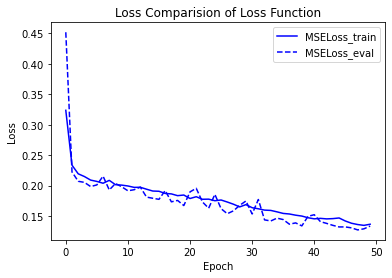

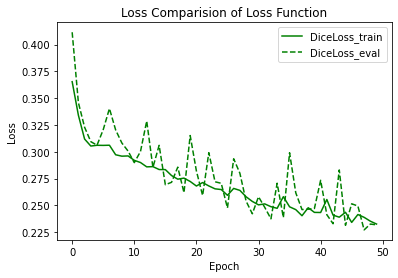

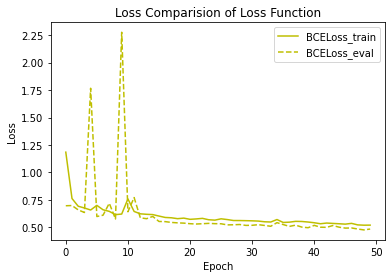

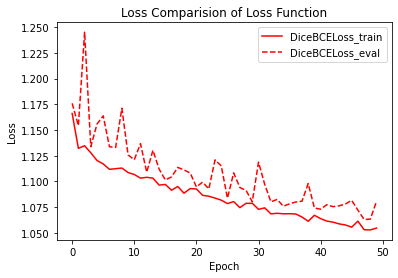

In [15]:
x=np.arange(50)
colors=[['b-','b--'],['g-','g--'],['y-','y--'],['r-','r--']]
for i in range(4):
    plt.plot(x,Losses[i][0],colors[i][0],label=names[i]+'_train')    
    plt.plot(x,Losses[i][1],colors[i][1],label=names[i]+'_eval')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparision of Loss Function')
    plt.legend()
    plt.show()

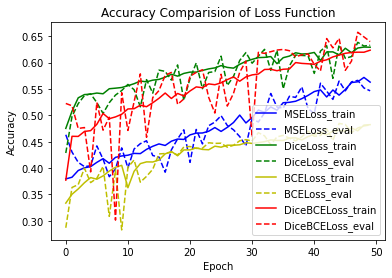

In [16]:
for i in range(4):
    plt.plot(x,Accuracies[i][0],colors[i][0],label=names[i]+'_train')    
    plt.plot(x,Accuracies[i][1],colors[i][1],label=names[i]+'_eval')
    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision of Loss Function')
plt.legend()
plt.show()

- It seems that the accuracies of DiceBCELoss and DiceLoss are higher than that of MSELoss and BCELoss.   
- The BCELoss has the lowest accuracy and its loss value decreases very slowly after 10 epochs. 
- The eval loss curve of DiceLoss are smoother than that of DiceBCELoss

To better show the prediction results, I selected 8 images from train, eval, and test sets respectivly and show their predicted masks.

- The order of the columns are: Train, Label, MSE, DiceLoss, BCE, DiceBCE Loss

In [17]:
num_figure=8
imgs=np.arange(num_figure)*10
unet=UNet().cuda()

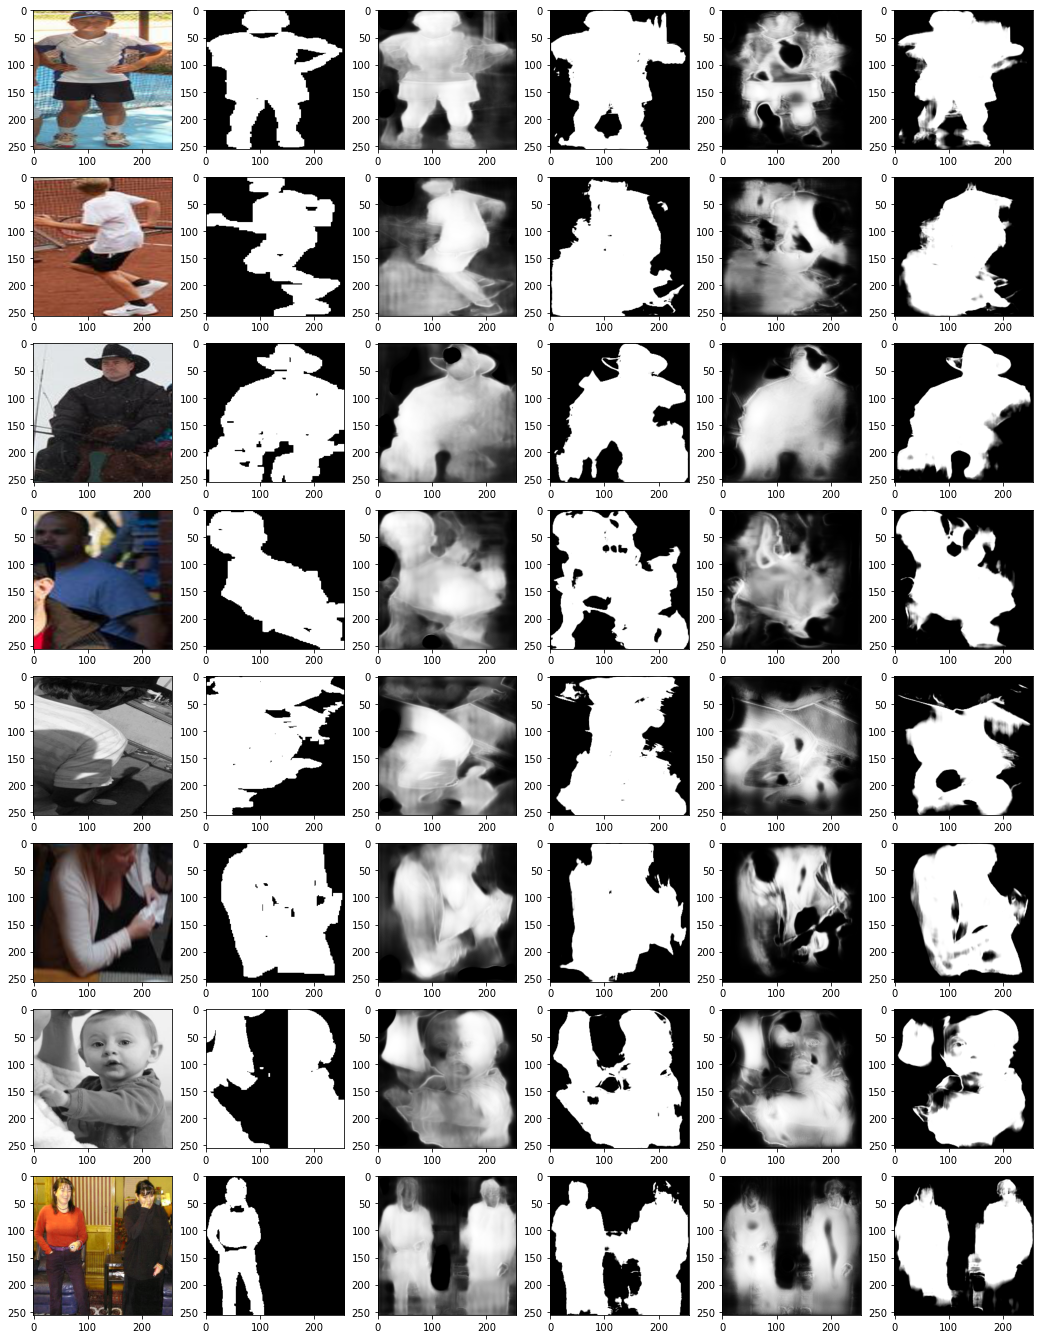

In [18]:
plt.figure(figsize=(18,24))

count=1

for i in imgs:
    
    im,label=train_data.__getitem__(i)
    
    plt.subplot(num_figure,6,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    count+=1
    
    
    plt.subplot(num_figure,6,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    count+=1
    
    for j in range(4):
        
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,6,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))
        if i==1:
            plt.title(names[j]) 
        count+=1

plt.show()

        Image                  Mask                     MSE                     Dice                     BCE                     Dice BCE

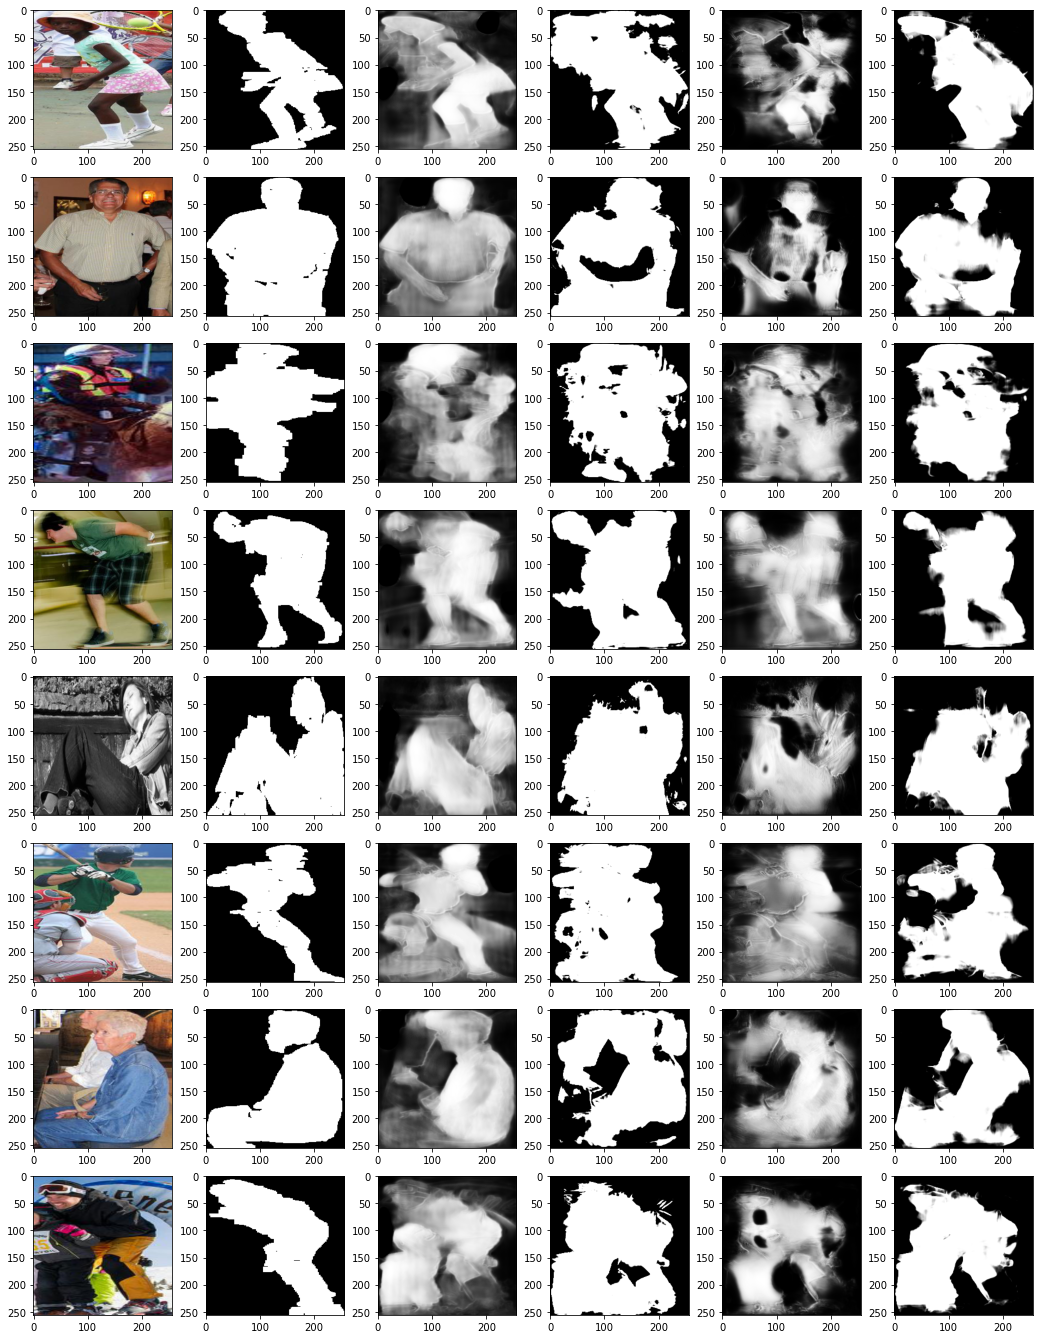

In [19]:
plt.figure(figsize=(18,24))

count=1

for i in imgs:
    
    im,label=eval_data.__getitem__(i)
    
    plt.subplot(num_figure,6,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    count+=1
    
    
    plt.subplot(num_figure,6,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    count+=1
    
    for j in range(4):
        
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        ax=plt.subplot(num_figure,6,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))    
        count+=1
        if i==1:
            plt.title(names[j]) 


plt.show()


        Image                  Mask                     MSE                     Dice                     BCE                     Dice BCE

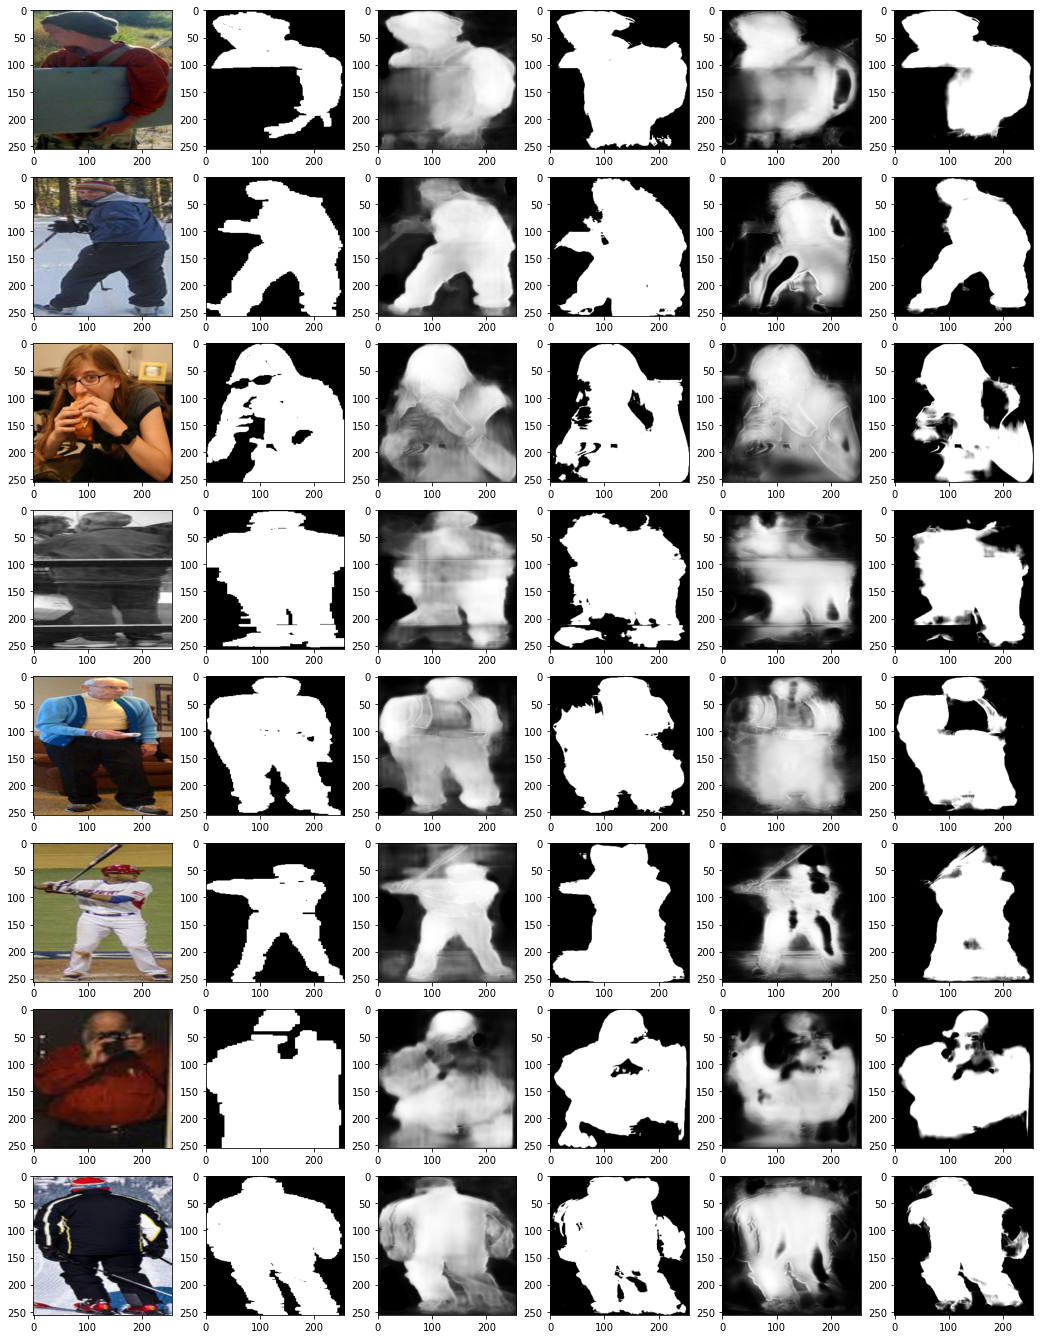

In [20]:
test_data=MyDataSet('test',test_transfrom)
plt.figure(figsize=(18,24))

count=1

for i in imgs:
    
    im,label=test_data.__getitem__(i)
    
    plt.subplot(num_figure,6,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    count+=1
    
    
    plt.subplot(num_figure,6,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    count+=1
    
    for j in range(4):
        
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,6,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))    
        if i==1:
            plt.title(names[j]) 
        count+=1

plt.show()

        Image                  Mask                     MSE                     Dice                     BCE                     Dice BCE

- The ouputof Dice Loss are in black and white while others has some gray parts
- Although the color of Dice Loss is more clear, the shapes are not so accurate
- The mask shapes of MSE Loss seems a liitle better than that of Dice Loss and Dice BCELoss
- The BCELoss seems performed the worst
- Since it is only 50E, none of them has serious overfitting problem
- It might need more epochs to compare their performances.